<a href="https://colab.research.google.com/github/stellagerantoni/learning-time-series-counterfactuals/blob/main/multivariate_pendigits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! git clone https://github.com/stellagerantoni/learning-time-series-counterfactuals
%cd learning-time-series-counterfactuals/

Cloning into 'learning-time-series-counterfactuals'...
remote: Enumerating objects: 352, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 352 (delta 142), reused 168 (delta 120), pack-reused 138
Receiving objects: 100% (352/352), 5.69 MiB | 18.21 MiB/s, done.
Resolving deltas: 100% (211/211), done.
/content/learning-time-series-counterfactuals/learning-time-series-counterfactuals


In [3]:

!pip install -q wildboar
!pip install -q scikit-learn
!pip install -q stumpy
!pip install -q fastdtw
!pip install aeon[all_extras]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.0/39.0 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.1/812.1 kB 49.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import logging
import os
import warnings
from argparse import ArgumentParser
from aeon.datasets import load_classification

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals

from _composite import ModifiedLatentCF
%cd src
from _vanilla import LatentCF
from help_functions import (ResultWriter, conditional_pad, evaluate,
                            find_best_lr, plot_graphs,
                            reset_seeds, time_series_normalize,
                            time_series_revert, upsample_minority,
                            validity_score)
from keras_models import *

/content/learning-time-series-counterfactuals/learning-time-series-counterfactuals/src


In [5]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
RANDOM_STATE = 39

## **FUNCTIONS**

In [6]:
def load_dataset(dataset):
  X, y, meta_data = load_classification(dataset)
  if dataset == 'Heartbeat':
    pos = 'normal'
    neg = 'abnormal'
    X = X.transpose(0,2,1)
  if dataset == 'SelfRegulationSCP1':
    pos = 'positivity'
    neg = 'negativity'
    X = X.transpose(0,2,1)
  if dataset == 'Cricket':
    return X,y,meta_data
  if dataset == 'SpokenArabicDigits':
    return X,y,meta_data
  if dataset == 'PenDigits':
    return X,y,meta_data

  print(" Shape of X = ", X.shape)
  print(" Shape of y = ", y.shape)
  print(" Meta data = ", meta_data)
  # Convert positive and negative labels to 1 and 0
  pos_label, neg_label = 1, 0
  if pos != pos_label:
      y[y==pos] = pos_label # convert/normalize positive label to 1
  if neg != neg_label:
      y[y==neg] = neg_label # convert negative label to 0

  y = y.astype(int)
  print(f"\n X[:1] = \n{X[:1]}")
  return X,y,pos_label, neg_label

In [7]:
from sklearn.utils import resample, shuffle
def upsample_minority_multivariate(X, y, random_state=39):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    max_count = max(class_counts)

    X_resampled_list = []
    y_resampled_list = []

    for cls in unique_classes:
        X_cls = X[y == cls]
        y_cls = y[y == cls]

        # Resample the current class data to match the max count
        X_cls_resampled, y_cls_resampled = resample(X_cls, y_cls,
                                                    replace=True, # sample with replacement (upsample)
                                                    n_samples=max_count, # match the number in majority class
                                                    random_state=random_state) # reproducible results

        X_resampled_list.append(X_cls_resampled)
        y_resampled_list.append(y_cls_resampled)

    # Vertically stack the resampled data for each class
    X_resampled = np.vstack(X_resampled_list)
    y_resampled = np.hstack(y_resampled_list)
    X_concat, y_concat = shuffle(X_resampled, y_resampled, random_state=random_state)

    return X_resampled, y_resampled


In [39]:

def visualise_digit(X,y,idx):
  print(f'y = {y[idx]}')
  X = X.transpose (0,2,1)
  x_coords = X[idx, 0]
  y_coords = X[idx,1]
  plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
  plt.plot(x_coords, y_coords, marker='o', linestyle='-')
  plt.title("Handwritten Digit 3")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.grid(True)
  plt.show()

def visualise_decoded_digit(X,y):
  print(f'y = {y}')
  X = X.transpose (0,2,1)
  x_coords = X[0,0]
  y_coords = X[0,1]
  plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
  plt.plot(x_coords, y_coords, marker='o', linestyle='-')
  plt.title("Handwritten Digit 3")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.grid(True)
  plt.show()

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


def normalize_multivariate(data, n_timesteps, n_features, scaler=None):

    # Then reshape data to have timesteps as rows for normalization
    data_reshaped = data.reshape(-1, n_features)

    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(data_reshaped)

    normalized = scaler.transform(data_reshaped)

    # Return data reshaped
    data = normalized.reshape(-1, n_timesteps, n_features)
    return data, scaler

def conditional_pad_multivariate(X):
    num_timesteps = X.shape[1]

    if num_timesteps % 4 != 0:
        next_num = (int(num_timesteps / 4) + 1) * 4
        padding_size = next_num - num_timesteps
        X_padded = np.pad(
            X, pad_width=((0, 0), (0, padding_size), (0, 0))
        )

        return X_padded, padding_size

    return X, 0



# **ACTUALL CODE**
datasets available : 'Heartbeat', 'SelfRegulationSCP1'

In [18]:
X,y,data_information = load_dataset('PenDigits')
print(f'shape of X = {X.shape}')
print(f'shape of y = {y.shape}')
print(f'data imformation = {data_information}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f'shape of X train = {X_train.shape}')
print(f'shape of y train = {y_train.shape}')

shape of X = (10992, 2, 8)
shape of y = (10992,)
data imformation = {'problemname': 'pendigits', 'timestamps': False, 'missing': False, 'univariate': False, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}
shape of X train = (8793, 2, 8)
shape of y train = (8793,)


In [19]:
# Upsample the minority class
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'before: {class_counts}')
X_train,y_train = upsample_minority_multivariate(X_train,y_train)
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'after: {class_counts}')

before: [914 914 915 844 915 844 845 914 844 844]
after: [915 915 915 915 915 915 915 915 915 915]


In [20]:
X_train = X_train.transpose (0,2,1)
X_test = X_test.transpose(0,2,1)
n_training,n_timesteps, n_features= X_train.shape

X_train_processed, trained_scaler =  normalize_multivariate(data=X_train, n_timesteps=n_timesteps, n_features = n_features)
X_test_processed, _ =  normalize_multivariate(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler, n_features = n_features)

X_train_processed_padded, padding_size = conditional_pad_multivariate(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad_multivariate(X_test_processed)

n_timesteps_padded = X_train_processed_padded.shape[1]
print(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")

#check the processing (0,1) min should be min 0 and max should be max 1
print(f"\nmin value = {np.min(X_train)}, max value = {np.max(X_train)}")
print(f"min value normalized = {np.min(X_train_processed)}, max value normalized= {np.max(X_train_processed)}")

#check that padding paddes the right dimention
print(f"\nX_train.shape = {X_train.shape}" )
print(f"X_train_processed_padded.shape = {X_train_processed_padded.shape}")


Data pre-processed, original #timesteps=8, padded #timesteps=8.

min value = 0.0, max value = 100.0
min value normalized = 0.0, max value normalized= 1.0

X_train.shape = (9150, 8, 2)
X_train_processed_padded.shape = (9150, 8, 2)


In [21]:
zero_indices_train = np.where(y_train == '0')[0]
eight_indices_train = np.where(y_train == '8')[0]
zero_indices_test = np.where(y_test == '0')[0]
eight_indices_test = np.where(y_test == '8')[0]

# Filter data based on the indices
X_train_zeroes = X_train_processed_padded[zero_indices_train]
y_train_zeroes = y_train[zero_indices_train]

X_train_eights = X_train_processed_padded[eight_indices_train]
y_train_eights = y_train[eight_indices_train]

X_test_zeroes = X_test_processed_padded[zero_indices_test]
y_test_zeroes = y_test[zero_indices_test]

X_test_eights = X_test_processed_padded[eight_indices_test]
y_test_eights = y_test[eight_indices_test]

# Concatenate data
X_train = np.concatenate([X_train_zeroes, X_train_eights])
y_train = np.concatenate([y_train_zeroes, y_train_eights])
X_test = np.concatenate([X_test_zeroes, X_test_eights])
y_test = np.concatenate([y_test_zeroes, y_test_eights])

# Shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_STATE)
X_test, y_test = shuffle(X_test, y_test, random_state=RANDOM_STATE)


In [22]:
for i in range(y_train.shape[0]):
  if y_train[i] == '8':
    y_train[i]=1
  else:
    y_train [i]=0
for i in range(y_test.shape[0]):
  if y_test[i] == '8':
    y_test[i]=1
  else:
    y_test[i]=0
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_train_classes = y_train
y_test_classes = y_test
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, len(np.unique(y_train)))
y_test = to_categorical(y_test, len(np.unique(y_test)))

In [23]:
from keras.regularizers import l2
def Classifier(
    n_timesteps, n_features, n_conv_layers=1, add_dense_layer=True, n_output=2
):
    # https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

    input_shape = ( n_timesteps,n_features)

    inputs = keras.Input(shape=input_shape, dtype="float32")


    if add_dense_layer:
        x = keras.layers.Dense(128)(inputs)
    else:
        x = inputs

    for i in range(n_conv_layers):
        x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)

    x = keras.layers.MaxPooling1D(pool_size=2, padding="same")(x)
    x = keras.layers.Flatten()(x)

    if n_output >= 2:
        outputs = keras.layers.Dense(n_output, activation="softmax")(x)
    else:
        outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    classifier = keras.models.Model(inputs=inputs, outputs=outputs)

    return classifier

In [24]:


# ## 2. LatentCF models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()
###############################################
# ### 1dCNN classifier

cnnClassifier = Classifier(
    n_timesteps_padded, n_features, n_output=2, add_dense_layer = False
)

optimizer = keras.optimizers.Adam(lr=0.001)
cnnClassifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=30, restore_best_weights=True
)
# Train the model
reset_seeds()
print("Training log for LSTM-FCN classifier:")
classifier_history = cnnClassifier.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=12,
    shuffle=True,
    verbose=True,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping_accuracy],
)

y_pred = cnnClassifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:8", "True:0"],
    columns=["Pred:8", "Pred:0"],
)
print(confusion_matrix_df)


Training log for LSTM-FCN classifier:
Epoch 1/150
153/153 [==============================] - 4s 10ms/step - loss: 0.1881 - accuracy: 0.9426 - val_loss: 0.4269 - val_accuracy: 0.9773
Epoch 2/150
153/153 [==============================] - 1s 8ms/step - loss: 0.0466 - accuracy: 0.9902 - val_loss: 0.1765 - val_accuracy: 0.9864
Epoch 3/150
153/153 [==============================] - 1s 8ms/step - loss: 0.0253 - accuracy: 0.9951 - val_loss: 0.0547 - val_accuracy: 0.9932
Epoch 4/150
153/153 [==============================] - 1s 6ms/step - loss: 0.0173 - accuracy: 0.9967 - val_loss: 0.0248 - val_accuracy: 0.9886
Epoch 5/150
153/153 [==============================] - 1s 5ms/step - loss: 0.0128 - accuracy: 0.9978 - val_loss: 0.0151 - val_accuracy: 0.9977
Epoch 6/150
153/153 [==============================] - 1s 5ms/step - loss: 0.0100 - accuracy: 0.9984 - val_loss: 0.0147 - val_accuracy: 0.9977
Epoch 7/150
153/153 [==============================] - 1s 6ms/step - loss: 0.0073 - accuracy: 0.9995 - 

In [ ]:
def Autoencoder_multivariate(n_features, n_timesteps):

    def Encoder(input):
        x = keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding="same")(input)
        print("Encoder Conv1:", x.shape)
        return x

    def Decoder(input):
        x = keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding="same")(input)
        print("Decoder Conv1:", x.shape)
        x = keras.layers.Conv1D(filters=n_timesteps, kernel_size=3, activation="linear", padding="same")(x) # This will set depth back to 2
        print("Decoder Conv2:", x.shape)
        return x

    orig_input = keras.Input(shape=(n_features, n_timesteps))
    autoencoder = keras.Model(inputs=orig_input, outputs=Decoder(Encoder(orig_input)))
    return autoencoder

In [36]:
def Autoencoder(n_timesteps, n_features):
    # Define encoder and decoder structure
    def Encoder(input):
        x = keras.layers.Conv1D(
            filters=64, kernel_size=3, activation="relu", padding="same"
        )(input)
        x = keras.layers.MaxPool1D(pool_size=2, padding="same")(x)
        x = keras.layers.Conv1D(
            filters=32, kernel_size=3, activation="relu", padding="same"
        )(x)
        x = keras.layers.MaxPool1D(pool_size=2, padding="same")(x)
        return x

    def Decoder(input):
        x = keras.layers.Conv1D(
            filters=32, kernel_size=3, activation="relu", padding="same"
        )(input)
        x = keras.layers.UpSampling1D(size=2)(x)
        x = keras.layers.Conv1D(
            filters=64, kernel_size=3, activation="relu", padding="same"
        )(x)
        # x = keras.layers.Conv1D(filters=64, kernel_size=2, activation="relu")(x)
        x = keras.layers.UpSampling1D(size=2)(x)
        x = keras.layers.Conv1D(
            filters=n_features, kernel_size=3, activation="linear", padding="same"
        )(x)
        return x

    # Define the AE model
    orig_input = keras.Input(shape=(n_timesteps, n_features))
    autoencoder = keras.Model(inputs=orig_input, outputs=Decoder(Encoder(orig_input)))

    return autoencoder

In [26]:
X_train.shape

(1830, 8, 2)

In [25]:
X_test.shape

(440, 8, 2)

In [37]:
reset_seeds()


# ### 1dCNN autoencoder
autoencoder = Autoencoder( n_timesteps_padded,n_features)
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
# Train the model
reset_seeds()
print("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=12,
    shuffle=True,
    verbose=2,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping])

ae_val_loss = np.min(autoencoder_history.history['val_loss'])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")


Training log for 1dCNN autoencoder:
Epoch 1/50
153/153 - 4s - loss: 0.0639 - val_loss: 0.0243 - 4s/epoch - 29ms/step
Epoch 2/50
153/153 - 1s - loss: 0.0143 - val_loss: 0.0100 - 1s/epoch - 8ms/step
Epoch 3/50
153/153 - 1s - loss: 0.0069 - val_loss: 0.0061 - 1s/epoch - 8ms/step
Epoch 4/50
153/153 - 1s - loss: 0.0043 - val_loss: 0.0046 - 1s/epoch - 8ms/step
Epoch 5/50
153/153 - 1s - loss: 0.0034 - val_loss: 0.0040 - 903ms/epoch - 6ms/step
Epoch 6/50
153/153 - 1s - loss: 0.0028 - val_loss: 0.0031 - 756ms/epoch - 5ms/step
Epoch 7/50
153/153 - 1s - loss: 0.0024 - val_loss: 0.0027 - 816ms/epoch - 5ms/step
Epoch 8/50
153/153 - 1s - loss: 0.0021 - val_loss: 0.0024 - 737ms/epoch - 5ms/step
Epoch 9/50
153/153 - 1s - loss: 0.0018 - val_loss: 0.0022 - 828ms/epoch - 5ms/step
Epoch 10/50
153/153 - 1s - loss: 0.0017 - val_loss: 0.0021 - 779ms/epoch - 5ms/step
Epoch 11/50
153/153 - 1s - loss: 0.0015 - val_loss: 0.0019 - 728ms/epoch - 5ms/step
Epoch 12/50
153/153 - 1s - loss: 0.0014 - val_loss: 0.0018 -

In [35]:
autoencoded_sample.shape

(1, 8, 1)

1/1 [==============================] - 0s 47ms/step
y = [[0. 1.]]


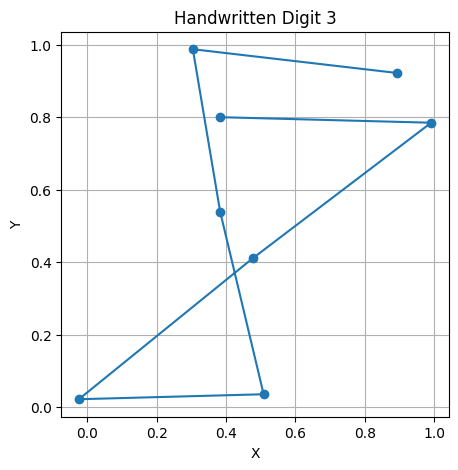

y = [0. 1.]


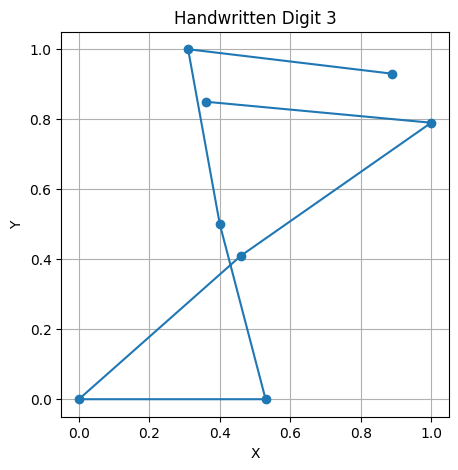

In [40]:
idx = 0
sample = X_test[idx:idx+1]
sample_label = y_test[idx:idx+1]
autoencoded_sample = autoencoder.predict(sample)
visualise_decoded_digit(autoencoded_sample,sample_label)
visualise_digit(X_test,y_test,idx)

In [61]:
def get_global_weights_new1(
    input_samples, input_labels, classifier_model, n_timesteps, n_features, random_state=None,
):
    n_samples, _, _ = input_samples.shape

    class ModelWrapper:
        def __init__(self, model, n_timesteps, n_features):
            self.model = model
            self.fitted_ = False
            self.n_timesteps_in_ = n_timesteps
            self.n_features_in_ = n_features

        def predict(self, X):
            p = self.model.predict(reshaped_X)
            return np.argmax(p, axis=1)

        def fit(self, X, y):
            reshaped_X = X.reshape(-1, self.n_timesteps_in_, self.n_features_in_)
            self.fitted_ = True
            return self.model.fit(reshaped_X, y)

    clf = ModelWrapper(classifier_model, n_timesteps, n_features)

    # Flattening the multivariate series
    i = IntervalImportance(scoring="accuracy", n_intervals=n_timesteps, random_state=random_state)
    i.fit(clf, input_samples.reshape(n_samples, n_timesteps * n_features), input_labels)

    # Calculate the threshold of masking, 75 percentile
    masking_threshold = np.percentile(i.importances_.mean, 75)
    masking_idx = np.where(i.importances_.mean >= masking_threshold)

    # Initialize the weights to ones for all timesteps and features
    weighted_steps = np.ones((n_timesteps, n_features))

    # Mask across all features for identified timesteps
    seg_idx = i.components_
    for start_idx in masking_idx[0]:
        weighted_steps[seg_idx[start_idx][0]:seg_idx[start_idx][1], :] = 0

    # Reshape for multiplication in `tf.math.multiply()`
    weighted_steps = weighted_steps.reshape(1, n_timesteps, n_features)
    return weighted_steps


In [52]:
import warnings

import numpy as np
import tensorflow as tf
from tensorflow import keras

from wildboar.explain import IntervalImportance
from LIMESegment.Utils.explanations import LIMESegment
def get_global_weights_new(
    input_samples, input_labels, classifier_model, n_timesteps, n_features, random_state=None,
):
    n_samples, _, _ = input_samples.shape

    class ModelWrapper:
        def __init__(self, model, n_timesteps, n_features):
            self.model = model
            self.fitted_ = False
            self.n_timesteps_in_ = n_timesteps
            self.n_features_in_ = n_features

        def predict(self, X):
            p = self.model.predict(X.reshape(n_samples, n_timesteps, n_features))
            return np.argmax(p, axis=1)

        def fit(self, X, y):
            self.fitted_ = True
            return self.model.fit(X, y)

    clf = ModelWrapper(classifier_model, n_timesteps, n_features)

clf = ModelWrapper(classifier_model, n_timesteps, n_features)

    # Initialize IntervalImportance
    i = IntervalImportance(
        scoring="accuracy",
        n_intervals=n_timesteps,  # Explicitly setting intervals based on original timesteps
        random_state=random_state
    )

    # Flatten the input_samples for the fit method
    flattened_samples = input_samples.reshape(n_samples, n_timesteps * n_features)

    # Fit IntervalImportance
    i.fit(clf, flattened_samples, input_labels)


    # Flattening the multivariate series
    i = IntervalImportance(scoring="accuracy", n_intervals=10, random_state=random_state)
    i.fit(clf, input_samples.reshape(n_samples, n_timesteps * n_features), input_labels)

    # Calculate the threshold of masking, 75 percentile
    masking_threshold = np.percentile(i.importances_.mean, 75)
    masking_idx = np.where(i.importances_.mean >= masking_threshold)

    # Initialize the weights to ones for all timesteps and features
    weighted_steps = np.ones((n_timesteps, n_features))

    # Mask across all features for identified timesteps
    seg_idx = i.components_
    for start_idx in masking_idx[0]:
        weighted_steps[seg_idx[start_idx][0]:seg_idx[start_idx][1], :] = 0

    # Reshape for multiplication in `tf.math.multiply()`
    weighted_steps = weighted_steps.reshape(1, n_timesteps, n_features)
    return weighted_steps


In [65]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [0.5]
from help_functions import evaluate2
w_type = "uniform"
pos_label = 1
neg_label = 0

if w_type == "global":
    step_weights = get_global_weights_new1(
        X_train,
        y_train_classes,
        cnnClassifier,
        n_timesteps= n_timesteps,
        n_features=n_features,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )
### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    print(f"The current prediction margin weight is {pred_margin_weight}.")

    # get the negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test[y_pred_classes == neg_label][:10]
    y_pred_neg = y_pred_classes[y_pred_classes==neg_label][:10]
    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, _ = find_best_lr(
        cnnClassifier,
        X_pred_neg,
        y_pred_neg,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

    # predicted probabilities of CFs
    z_pred = cnnClassifier.predict(best_cf_samples)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation in 1dCNN autoencoder
        best_cf_samples = best_cf_samples[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg

    evaluate_res = evaluate2(
        X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
    )

The current prediction margin weight is 0.5.
======================== CF search started, with lr=0.0001.
1 samples been transformed.
10 samples been transformed, in total.
1/1 [==============================] - 0s 30ms/step
lr=0.0001 finished. Validity: 0.0, proximity: 0.031635776945159136.
The best learning rate found is 0.0001.
1/1 [==============================] - 0s 30ms/step
